In [4]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, clear_output
from functools import partial

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

from src.config import Config
from src.episode import Episode
from src.episode_dataset import EpisodeDataset
from src.rl_data_record import RLDataRecord
from src.policy_factory import PolicyMode, PolicyFactory
from src.reward_model import RewardModel
from src.grpo_trainer import GRPOTrainer
from src.policy_model_utils import load_policy_model, save_policy_model, train_and_plot_policy, inference_and_plot_policy_v2
from src.utils import get_color, normalize_min_max, to_device_collate, top_k_sampling
from src.episode_batch_reat_sampler import EpisodeBatchRepeatSampler

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Setup
---

In [5]:
config = Config()
reward_model = RewardModel(config=config)
test_policy = PolicyFactory.create(policy_mode=PolicyMode.LINEAR_MODEL, config=config)

# Datasets

train_dataset = EpisodeDataset(config=config, split="TRAIN")
print(f"train_dataset : {len(train_dataset)}")

test_dataset = EpisodeDataset(config=config, split="TEST")
print(f"test_dataset : {len(test_dataset)}")

eval_dataset = EpisodeDataset(config=config, split="EVAL")
print(f"eval_dataset : {len(eval_dataset)}")


# DataLoaders
def get_data_loader(
    dataset: EpisodeDataset, batch_size: int, group_size: int, repeats: int
):
    batch_repeat_sampler = EpisodeBatchRepeatSampler(
        dataset=dataset,
        batch_size=batch_size,
        group_size=group_size,
        repeats=repeats,
    )
    # print(
    #     f"batch_repeat_sampler: {len(batch_repeat_sampler)},  {list(batch_repeat_sampler)}"
    # )
    # print(
    #     f"batch ids: {[e.episode_id for e in dataset.get_episods(batch_episode_indices=list(batch_repeat_sampler))]}"
    # )

    to_device_collate_configurable = partial(to_device_collate, config.device)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size * group_size,
        sampler=batch_repeat_sampler,
        collate_fn=to_device_collate_configurable,
    )
    print(f"data loader: {dataset.split}, {len(dataloader)}")
    return dataloader


train_dataloader = get_data_loader(
    dataset=train_dataset,
    batch_size=config.train_batch_size,
    group_size=config.episode_group_size,
    repeats=config.episode_steps,
)
test_dataloader = get_data_loader(
    dataset=test_dataset,
    batch_size=config.test_batch_size,
    group_size=config.episode_group_size,
    repeats=config.episode_steps,
)

eval_dataloader = get_data_loader(
    dataset=eval_dataset,
    batch_size=config.eval_batch_size,
    group_size=config.episode_group_size,
    repeats=config.episode_steps,
)

/Users/chengbai/ml/cheng_git/rf_agent/src/policy/linear_model_policy.py:38: FutureWarning: `nn.init.kaiming_uniform` is now deprecated in favor of `nn.init.kaiming_uniform_`.
  layer.weight = nn.init.kaiming_uniform(layer.weight)


train_dataset : 2000
test_dataset : 20
eval_dataset : 2000
data loader: TRAIN, 30
data loader: TEST, 15
data loader: EVAL, 15


In [7]:
# for idx, batch_data in enumerate(test_dataloader):
#     batch_episode_indices = batch_data.get("episode_idx")
#     print(
#         f"idx: {idx}, batch_items: {len(batch_episode_indices)}, batch ids: {[e.episode_id for e in test_dataset.get_episods(batch_episode_indices=batch_episode_indices)]}"
#     )

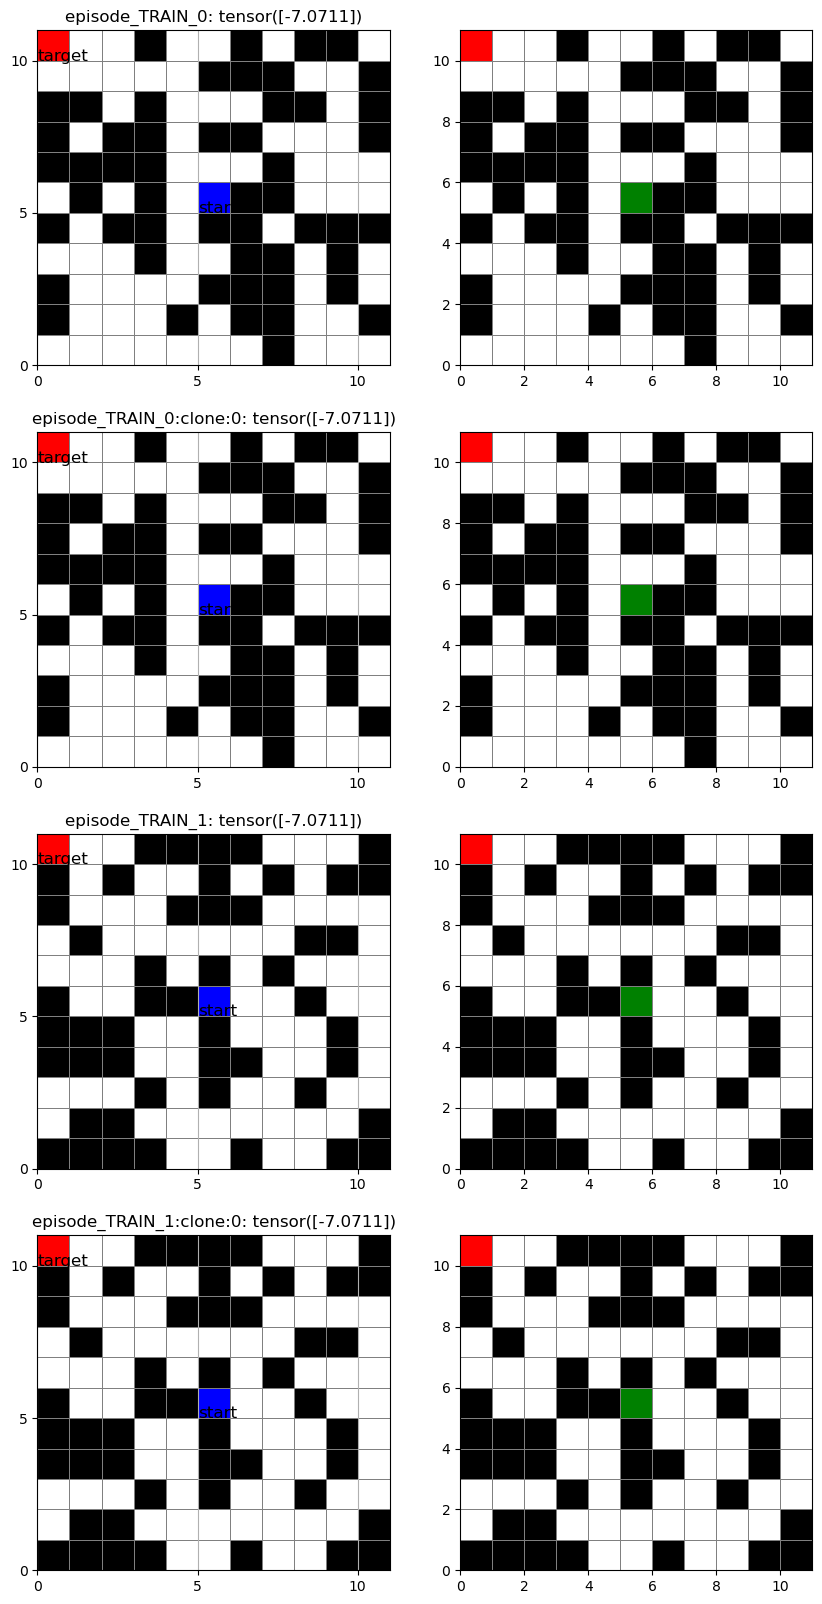

In [8]:
episode_samples = 4
fig, axes = plt.subplots(nrows=episode_samples, ncols=2, figsize=(10, 20))

for eidx in range(episode_samples):
    es = train_dataset.get_episode(eidx)

    es.viz(ax=axes[eidx][0], reward_model=reward_model)

    # Viz fov
    fov = es.fov(center_pos=es.agent.start_state.position())
    # print(f"fov: {fov.size()}, {fov}")
    # print(f"fov: {fov}")
    es.viz_fov(ax=axes[eidx][1])
plt.show()

# Training Loop
---

In [9]:
policy = PolicyFactory.create(policy_mode=PolicyMode.LINEAR_MODEL, config=config)
reward_model = RewardModel(config=config)
trainer = GRPOTrainer(config=config, policy=policy, reward_model=reward_model)

TEST:   0%|          | 0/15 [00:00<?, ?it/s]0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


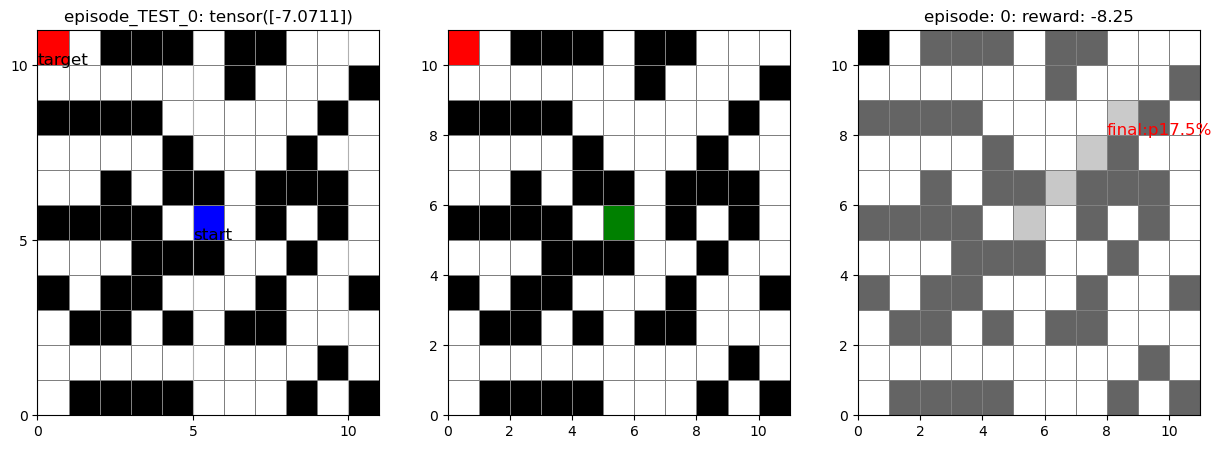

TEST:  20%|██        | 3/15 [00:00<00:00, 13.29it/s, split=TEST, batch_idx=2, is_episode_step_done=1, target_episodes=['episode_TEST_0', 'episode_TEST_0:clone:0', 'episode_TEST_1', 'episode_TEST_1:clone:0'], current_batch_episode_idx=[0, 1, 2, 3]]

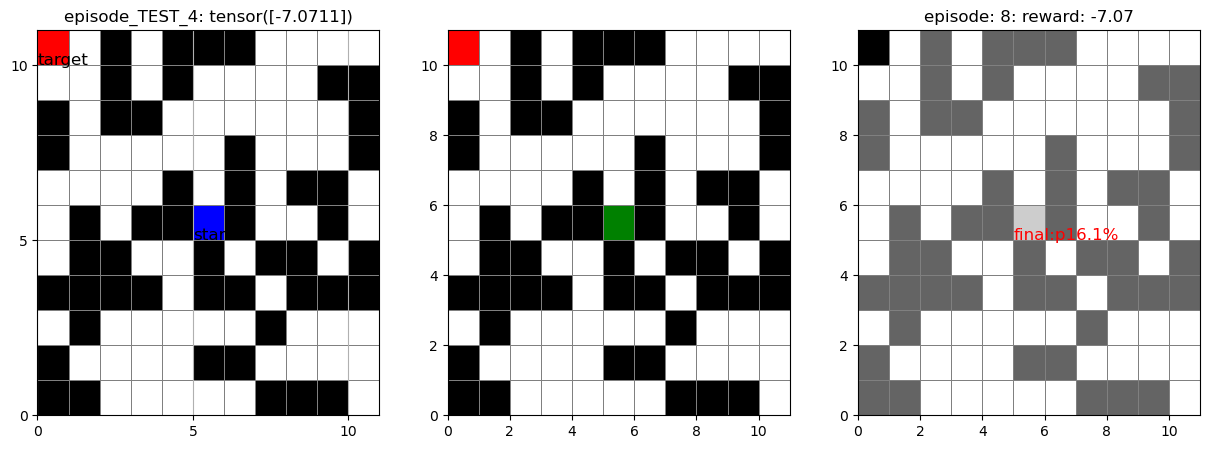

TEST:  40%|████      | 6/15 [00:00<00:00, 16.41it/s, split=TEST, batch_idx=5, is_episode_step_done=1, target_episodes=['episode_TEST_4', 'episode_TEST_4:clone:0', 'episode_TEST_5', 'episode_TEST_5:clone:0'], current_batch_episode_idx=[8, 9, 10, 11]]

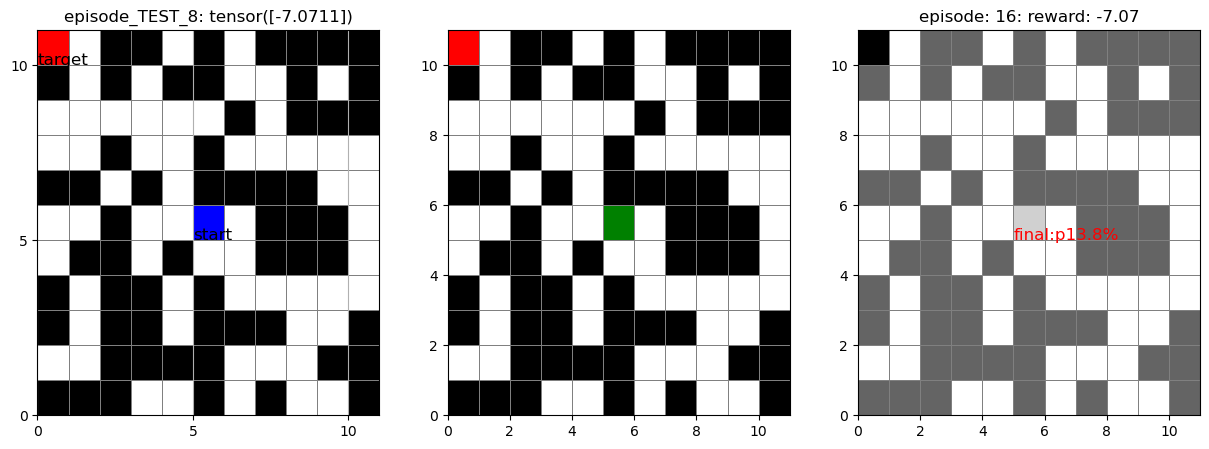

TEST:  60%|██████    | 9/15 [00:00<00:00, 18.95it/s, split=TEST, batch_idx=8, is_episode_step_done=1, target_episodes=['episode_TEST_8', 'episode_TEST_8:clone:0', 'episode_TEST_9', 'episode_TEST_9:clone:0'], current_batch_episode_idx=[16, 17, 18, 19]]

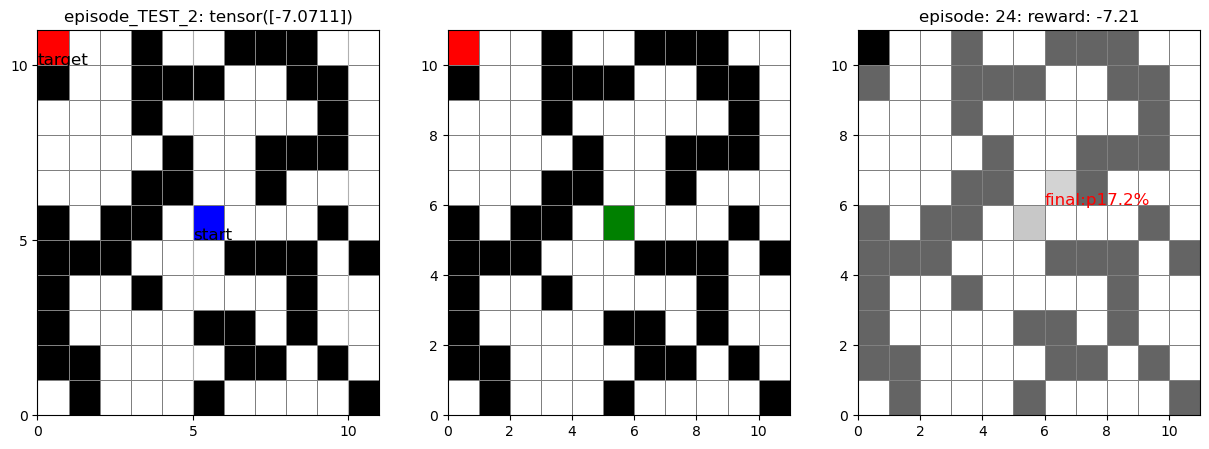

TEST:  80%|████████  | 12/15 [00:00<00:00, 19.79it/s, split=TEST, batch_idx=11, is_episode_step_done=1, target_episodes=['episode_TEST_2', 'episode_TEST_2:clone:0', 'episode_TEST_3', 'episode_TEST_3:clone:0'], current_batch_episode_idx=[24, 25, 26, 27]]

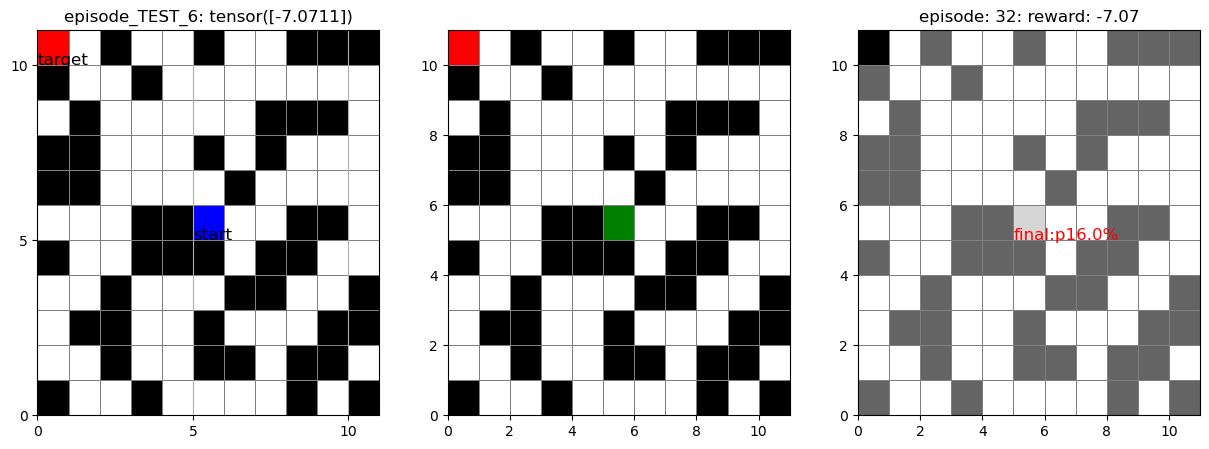

TEST: 100%|██████████| 15/15 [00:00<00:00, 19.31it/s, split=TEST, batch_idx=14, is_episode_step_done=1, target_episodes=['episode_TEST_6', 'episode_TEST_6:clone:0', 'episode_TEST_7', 'episode_TEST_7:clone:0'], current_batch_episode_idx=[32, 33, 34, 35]]


In [10]:
inference_and_plot_policy_v2(
    config=config,
    dataset=test_dataset,
    dataloader=test_dataloader,
    policy=policy,
    reward_model=reward_model,
)

In [11]:
# plt.ioff()
trainer.run(train_dataset=train_dataset, eval_dataset=eval_dataset, debug=False)
save_policy_model(policy=policy)

# plt.ion()

train_dataloader: 30, eval_dataloader: 15


Epoch 2: 100%|██████████| 15/15 [00:01<00:00, 11.15it/s, split=EVAL, step=10, batch_idx=14, is_episode_step_done=1]

model_path: rf_model_policy_20250527030448.pt
Save policy model to: rf_model_policy_20250527030448.pt


# Evaluate the Model
----

TEST:   0%|          | 0/15 [00:00<?, ?it/s]

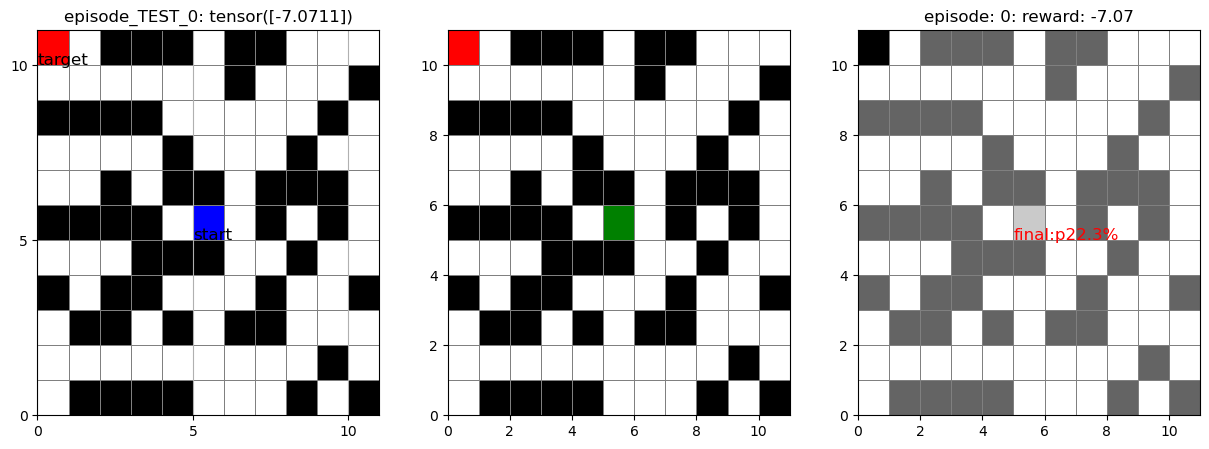

TEST:  20%|██        | 3/15 [00:00<00:00, 22.60it/s, split=TEST, batch_idx=2, is_episode_step_done=1, target_episodes=['episode_TEST_0', 'episode_TEST_0:clone:0', 'episode_TEST_1', 'episode_TEST_1:clone:0'], current_batch_episode_idx=[0, 1, 2, 3]]

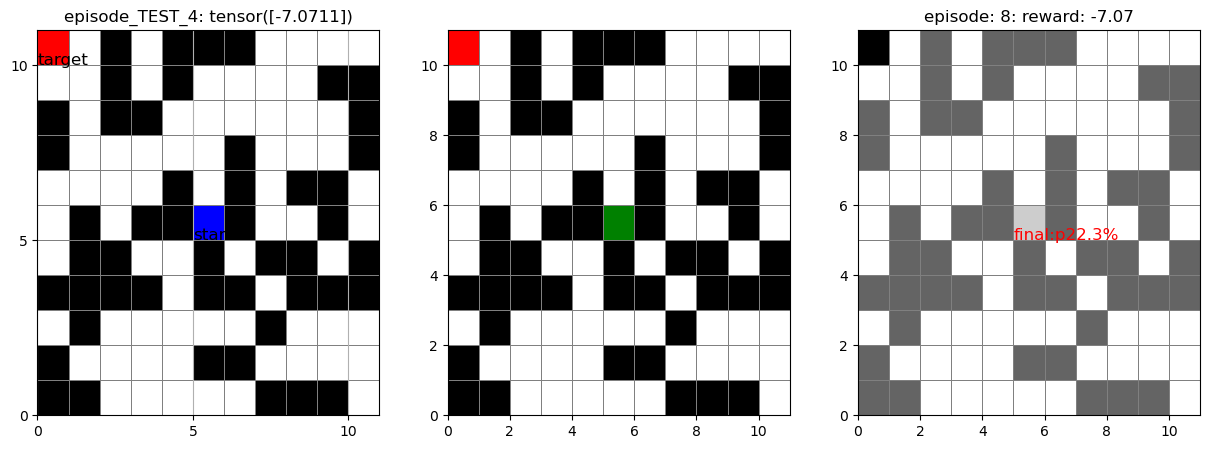

TEST:  40%|████      | 6/15 [00:00<00:00, 21.68it/s, split=TEST, batch_idx=5, is_episode_step_done=1, target_episodes=['episode_TEST_4', 'episode_TEST_4:clone:0', 'episode_TEST_5', 'episode_TEST_5:clone:0'], current_batch_episode_idx=[8, 9, 10, 11]]

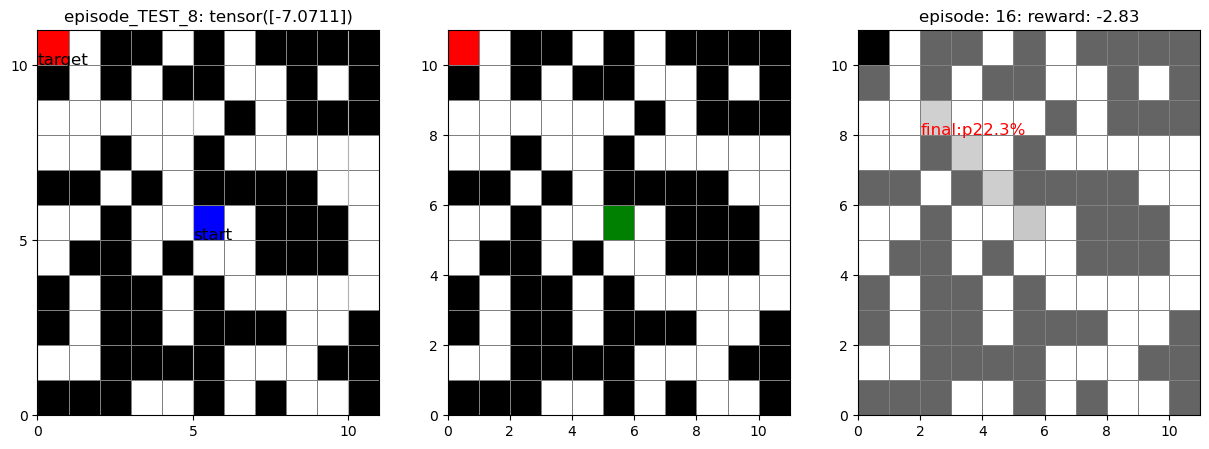

TEST:  60%|██████    | 9/15 [00:00<00:00, 22.11it/s, split=TEST, batch_idx=8, is_episode_step_done=1, target_episodes=['episode_TEST_8', 'episode_TEST_8:clone:0', 'episode_TEST_9', 'episode_TEST_9:clone:0'], current_batch_episode_idx=[16, 17, 18, 19]]

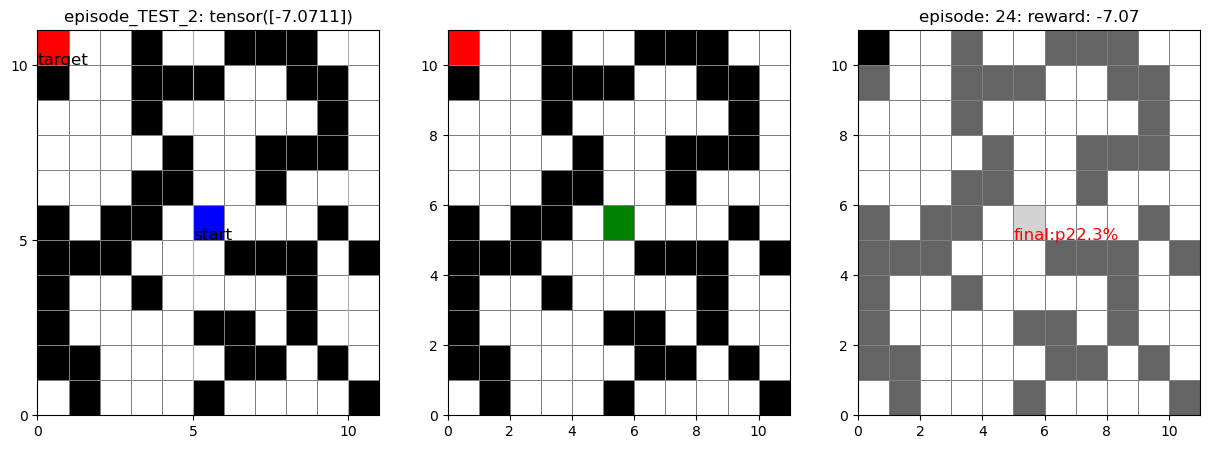

TEST:  80%|████████  | 12/15 [00:00<00:00, 22.30it/s, split=TEST, batch_idx=11, is_episode_step_done=1, target_episodes=['episode_TEST_2', 'episode_TEST_2:clone:0', 'episode_TEST_3', 'episode_TEST_3:clone:0'], current_batch_episode_idx=[24, 25, 26, 27]]

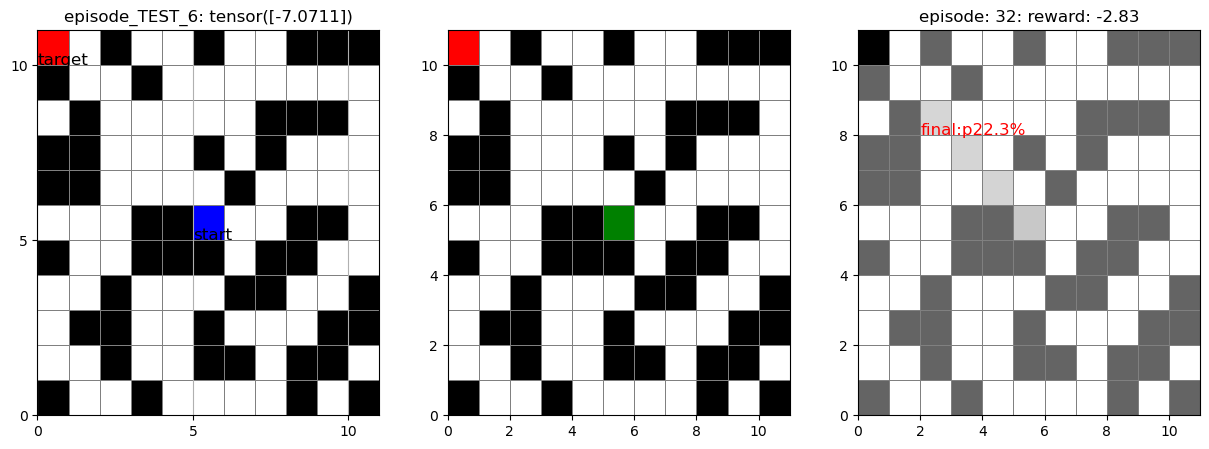

TEST: 100%|██████████| 15/15 [00:00<00:00, 20.03it/s, split=TEST, batch_idx=14, is_episode_step_done=1, target_episodes=['episode_TEST_6', 'episode_TEST_6:clone:0', 'episode_TEST_7', 'episode_TEST_7:clone:0'], current_batch_episode_idx=[32, 33, 34, 35]]


In [12]:
inference_and_plot_policy_v2(
    config=config,
    dataset=test_dataset,
    dataloader=test_dataloader,
    policy=policy,
    reward_model=reward_model,
)

In [ ]:
# print(f"episode reward: {episode.reward(reward_model=reward_model)}")

In [ ]:
# policy_model_path = (
#     "/Users/chengbai/ml/cheng_git/rf_agent/rf_model_policy_20250510230738_base.pt"
# )
# trained_policy = load_policy_model(config=config, policy_model_path=policy_model_path)
# assert trained_policy is not None

# episode = inference_and_plot_policy(
#     policy=trained_policy, config=config, reward_model=reward_model, steps=5, debug=True
# )